**Citation:** ChatGPT for reference

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
path = '/content/lfw'

In [ ]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("cuda")
else:
    print ("CUDA device not found.")


CUDA device not found.


torch.Size([250, 250, 3])


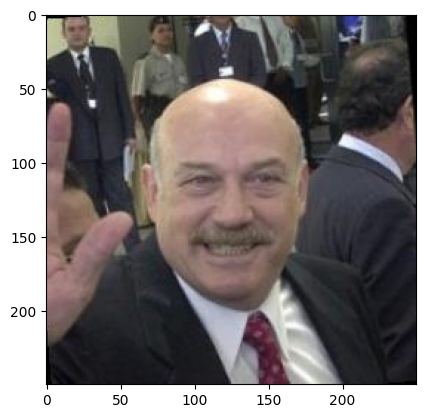

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [ ]:
# Step 2

# Iterating over the DataLoader to get a batch of images
for batch in dataloader:
    image_batch, _ = batch
    selected_image = image_batch[27]
    break

# Display the shape of the selected image
print("Shape of the selected image:", selected_image.shape)

# Explanation of the image dimensions
print("\nDetails of the image dimensions:")
print("Color Channels (1st Dimension):", selected_image.shape[0], "- Typically 3 for RGB images")
print("Image Height (2nd Dimension):", selected_image.shape[1], "- In pixels")
print("Image Width (3rd Dimension):", selected_image.shape[2], "- In pixels")


Dimensions of the sample image: torch.Size([3, 250, 250])

Explanation of each dimension:
1st Dimension (Channels): 3 - Number of color channels (3 for RGB)
2nd Dimension (Height): 250 - Height of the image in pixels
3rd Dimension (Width): 250 - Width of the image in pixels


The provided code snippet interacts with a DataLoader object, typically used in machine learning for handling datasets.

1. **Extracting a Single Image from the DataLoader**:
    - `for images, _ in dataloader:`: This line starts a loop over the DataLoader. The DataLoader returns batches of images. Each batch is represented by the variable `images`. The underscore `_` is a placeholder for labels or any other secondary data that we're not interested in this context.
    - `sample_image = images[27]`: This line selects the 28th image from the batch (since Python indexing starts at 0). This image is stored in the variable `sample_image`.
    - `break`: This line exits the loop after the first batch, ensuring that only one image is extracted.

2. **Printing the Dimensions of the Sample Image**:
    - `print("Dimensions of the sample image:", sample_image.shape)`: This line prints the shape of the `sample_image`. The shape is a tuple that represents the dimensions of the image.

3. **Explaining Each Dimension**:
    - The shape of an image is typically in the format `(channels, height, width)`.
        - **1st Dimension (Channels)**: Represents the number of color channels. For a standard RGB image, this is 3.
        - **2nd Dimension (Height)**: The height of the image in pixels.
        - **3rd Dimension (Width)**: The width of the image in pixels.



# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [ ]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(16)
        self.enc_relu1 = nn.ReLU()
        self.enc_conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(32)
        self.enc_relu2 = nn.ReLU()
        self.enc_conv3 = nn.Conv2d(32, 64, 7, padding=0)
        self.enc_bn3 = nn.BatchNorm2d(64)

        # Decoder Layers
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, 7, padding=0)
        self.dec_bn1 = nn.BatchNorm2d(32)
        self.dec_relu1 = nn.ReLU()
        self.dec_conv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=0)
        self.dec_bn2 = nn.BatchNorm2d(16)
        self.dec_relu2 = nn.ReLU()
        self.dec_conv3 = nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1)
        self.dec_sigmoid = nn.Sigmoid()

    def encoder(self, x):
        x = self.enc_relu1(self.enc_bn1(self.enc_conv1(x)))
        x = self.enc_relu2(self.enc_bn2(self.enc_conv2(x)))
        x = self.enc_bn3(self.enc_conv3(x))
        return x

    def decoder(self, x):
        x = self.dec_relu1(self.dec_bn1(self.dec_conv1(x)))
        x = self.dec_relu2(self.dec_bn2(self.dec_conv2(x)))
        x = self.dec_sigmoid(self.dec_conv3(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


The provided code defines a PyTorch class `AE`, representing an AutoEncoder (AE) neural network model. This class is a subclass of `nn.Module`, which is the base class for all neural network modules in PyTorch. The AE consists of two main parts: an encoder and a decoder, each composed of multiple layers. Let's break down the components:

#### Class Definition
- `class AE(nn.Module)`: Defines the AutoEncoder class inheriting from PyTorch's `nn.Module`.

#### Constructor `__init__(self)`
- `super(AE, self).__init__()`: Initializes the base class (`nn.Module`).

#### Encoder Layers
- **Convolutional Layers** (`self.enc_conv1`, `self.enc_conv2`, `self.enc_conv3`): These are 2D convolutional layers (`nn.Conv2d`) designed to extract spatial features from the input image. The first layer takes 3 channels as input (assuming RGB images), and the subsequent layers increase the channel depth.
- **Batch Normalization Layers** (`self.enc_bn1`, `self.enc_bn2`, `self.enc_bn3`): These layers (`nn.BatchNorm2d`) normalize the output of the convolutional layers to improve training stability and efficiency.
- **Activation Functions** (`self.enc_relu1`, `self.enc_relu2`): ReLU (Rectified Linear Unit) activation functions are used after some convolutional layers to introduce non-linearities into the model.

#### Decoder Layers
- **Transposed Convolutional Layers** (`self.dec_conv1`, `self.dec_conv2`, `self.dec_conv3`): These layers (`nn.ConvTranspose2d`) perform the inverse operation of convolutional layers, effectively 'upsampling' the feature maps to reconstruct the original input size.
- **Batch Normalization and Activation** (`self.dec_bn1`, `self.dec_bn2`, `self.dec_relu1`, `self.dec_relu2`): Similar to the encoder, these layers normalize the outputs and apply ReLU activations.
- **Final Layer** (`self.dec_sigmoid`): A sigmoid activation function is used in the final layer to ensure the output values are between 0 and 1, which is especially useful if the input data is normalized in the same way.

#### Methods
- `encoder(self, x)`: Defines the forward pass for the encoder part. It sequentially applies convolution, batch normalization, and ReLU layers, processing the input data down to a compressed representation.
- `decoder(self, x)`: Defines the forward pass for the decoder part. It sequentially applies transposed convolution, batch normalization, ReLU, and finally a sigmoid layer to reconstruct the input data from the compressed representation.
- `forward(self, x)`: Implements the complete forward pass of the autoencoder by calling the encoder and decoder methods in sequence. This is the method called during the model's training and inference phases.

#### Overall Functionality
The AE model aims to learn a compressed representation of the input data through the encoder and then reconstruct the input as closely as possible through the decoder. This architecture is useful in tasks like dimensionality reduction, feature learning, and denoising. The specific layer configurations and sizes are chosen based on the expected input data characteristics and the desired level of compression.

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [ ]:
# Create an instance of the AE class
model = AE()


# Input tensor (batch size, channels, height, width)
sample_input = images[0].unsqueeze(0)

# Check if CUDA is available and move the model and input to GPU if it is
if torch.cuda.is_available():
    model = model.cuda()
    sample_input = sample_input.cuda()

# Pass the dummy image through the model
with torch.no_grad():
    encoded_output = model.encoder(sample_input)
    decoded_output = model.decoder(encoded_output)

# Print the shapes of the outputs
print("Shape of encoded output:", encoded_output.shape)
print("Shape of decoded output:", decoded_output.shape)

Shape of encoded output: torch.Size([1, 64, 57, 57])
Shape of decoded output: torch.Size([1, 3, 250, 250])


The provided code demonstrates how to create an instance of the `AE` class, process a sample image through this model, and then print the shapes of the outputs from both the encoder and the decoder parts of the model. Let's break down the code:

1. **Creating an Instance of the AutoEncoder Class**:
   - `model = AE()`: This line creates an instance of the `AE` class. The `AE` class is assumed to be a custom-defined PyTorch module that implements an autoencoder architecture.

2. **Preparing the Input Tensor**:
   - `sample_input = images[0].unsqueeze(0)`: This line selects the first image from a presumed collection of images (`images[0]`) and adds an additional dimension at the beginning (`.unsqueeze(0)`), effectively creating a batch with a single image. In PyTorch, neural network models expect input in the form of batches, even if there's only one item in the batch.

3. **Checking for CUDA Availability**:
   - The `if` statement checks if CUDA (NVIDIA's parallel computing platform and programming model) is available, which would allow for GPU acceleration.
   - If CUDA is available, both the model (`model.cuda()`) and the input tensor (`sample_input.cuda()`) are transferred to the GPU. This step is essential for efficient computation when training or evaluating models with large datasets or complex architectures.

4. **Passing the Image Through the Model**:
   - The `with torch.no_grad():` context manager is used to deactivate autograd engine, which reduces memory usage and speeds up computations since it's not necessary to compute gradients during inference.
   - `encoded_output = model.encoder(sample_input)`: This line passes the input image through the encoder part of the autoencoder.
   - `decoded_output = model.decoder(encoded_output)`: This line passes the output of the encoder to the decoder.

5. **Printing the Output Shapes**:
   - `print("Shape of encoded output:", encoded_output.shape)`: Prints the shape of the encoded output. This output is typically a compressed representation of the input image.
   - `print("Shape of decoded output:", decoded_output.shape)`: Prints the shape of the decoded output, which should ideally be the same as the original input shape if the autoencoder is designed to reconstruct the input image.

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim

#Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

# Loss function
loss_function = nn.MSELoss()

optim = optim.Adam(model.parameters(), lr=0.001)

Total number of trainable parameters: 211603



# Total No. of Parameters
I printed out the Total No. of Parameters. It's essential to know the number of parameters in your model as it directly affects the model's capacity and memory usage during training and inference.

# Loss Function
I initialized the loss function to Mean Squared Error (MSE) loss. MSE loss is commonly used for image reconstruction tasks with autoencoders, where the goal is to minimize the squared difference between the original input and the reconstructed output. It measures the average squared difference between corresponding elements of the input and output tensors.

# Optimizer
I set up an Adam optimizer for training the model. Adam is a popular optimization algorithm that adapts the learning rates for each parameter during training, which often leads to faster convergence. It takes the model's parameters and a learning rate (lr) as arguments. The learning rate (0.001 in this case) controls the step size during gradient descent.


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
# Assuming model, loss_function, optim, and dataloader are already defined
num_epochs = 20  # Define the number of epochs

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for data in dataloader:
        inputs, _ = data

        # Check sizes
        #print(f"Input size: {inputs.size()}, Output size: {outputs.size()}")


        # Transfer to GPU if available
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        # Zero the parameter gradients
        optim.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optim.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")



Epoch 1, Loss: 0.0090
Epoch 2, Loss: 0.0019
Epoch 3, Loss: 0.0015
Epoch 4, Loss: 0.0013
Epoch 5, Loss: 0.0012
Epoch 6, Loss: 0.0010
Epoch 7, Loss: 0.0010
Epoch 8, Loss: 0.0009
Epoch 9, Loss: 0.0008
Epoch 10, Loss: 0.0008
Epoch 11, Loss: 0.0007
Epoch 12, Loss: 0.0007
Epoch 13, Loss: 0.0007
Epoch 14, Loss: 0.0006
Epoch 15, Loss: 0.0006
Epoch 16, Loss: 0.0006
Epoch 17, Loss: 0.0006
Epoch 18, Loss: 0.0005
Epoch 19, Loss: 0.0005
Epoch 20, Loss: 0.0005


The above code snippet is an example of a training loop in PyTorch for a neural network model. It's designed to iterate over a dataset for a specified number of epochs, updating the model's parameters in each iteration to minimize the loss.

1. **Number of Epochs**:
   - `num_epochs = 20`: This sets the number of epochs for the training loop. An epoch is one complete pass through the entire dataset.

2. **Training Loop**:
   - `for epoch in range(num_epochs)`: This loop iterates over the dataset multiple times, as defined by `num_epochs`.

3. **Epoch Loss Initialization**:
   - `epoch_loss = 0.0`: Initializes a variable to accumulate the loss for each epoch.

4. **Iterating Over the DataLoader**:
   - `for data in dataloader`: This inner loop iterates over the dataset, where `dataloader` provides batches of data.

5. **Data Preparation**:
   - `inputs, _ = data`: This extracts the input data from the batch. The underscore `_` is used to ignore the second element of the batch, typically labels or targets, not required for an autoencoder.

6. **GPU Compatibility**:
   - The `if torch.cuda.is_available()` block checks if a GPU is available and, if so, transfers the input data to the GPU for faster computation.

7. **Gradient Zeroing**:
   - `optim.zero_grad()`: Before the backward pass, it's necessary to zero out the gradients to prevent accumulation from previous forward passes.

8. **Forward Pass**:
   - `outputs = model(inputs)`: Passes the input data through the model to obtain the outputs.
   - `loss = loss_function(outputs, inputs)`: Calculates the loss by comparing the model's outputs to the original inputs (since this is likely an autoencoder).

9. **Backward Pass and Optimization**:
   - `loss.backward()`: Performs the backward pass to compute gradients.
   - `optim.step()`: Updates the model parameters based on the calculated gradients.

10. **Loss Accumulation**:
   - `epoch_loss += loss.item()`: Accumulates the loss for each batch.

11. **Reporting Average Epoch Loss**:
   - The epoch loss is averaged and printed at the end of each epoch, providing insight into how well the model is learning.

### Monitoring Loss and Troubleshooting

- **Monitor Loss**: The print statement at the end of each epoch reports the average loss. Monitoring this loss is crucial to understanding the model's learning progress. Ideally, the loss should decrease over time.
  
- **Troubleshooting**: If the loss is not decreasing, it could indicate issues such as:
  - **Improper Learning Rate**: If the learning rate is too high, the model may overshoot the minimum of the loss function. If it's too low, the model may not converge efficiently.
  - **Model Architecture Issues**: The model might be too simple or too complex for the task.
  - **Overfitting or Underfitting**: This can be diagnosed by comparing training and validation losses.
  - **Data Issues**: Poor quality or insufficient data can impede learning.
  - **Regularization**: Implementing techniques like dropout or L2 regularization can help if the model is overfitting.

Adjustments in these areas can help improve the model's learning performance.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

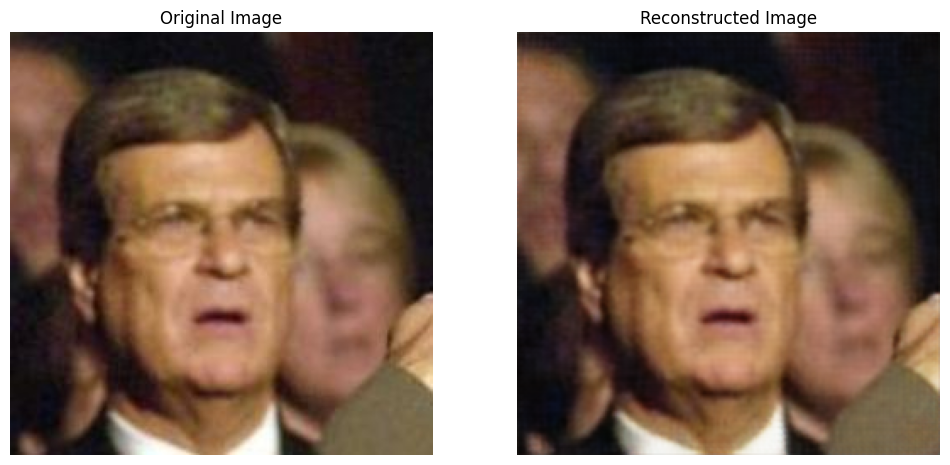

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch


data_iterator = iter(dataloader)
batch_images, batch_labels = next(data_iterator)

# Select a random image from the batch
random_index = torch.randint(len(batch_images), size=(1,)).item()
original_image = batch_images[random_index]

# Add a batch dimension and pass the image through the autoencoder
# Make sure the model is in evaluation mode and on the correct device
model.eval()
if torch.cuda.is_available():
    model = model.cuda()
    input_image = original_image.unsqueeze(0).cuda()
else:
    input_image = original_image.unsqueeze(0)

with torch.no_grad():
    reconstructed_image = model(input_image)

# Convert the images to numpy arrays for plotting
# Squeeze removes the batch dimension, and detach takes it out of the computation graph
original_image_np = original_image.squeeze().detach().cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy()

# Transpose the images from (C, H, W) to (H, W, C) for plotting
original_image_np = np.transpose(original_image_np, (1, 2, 0))
reconstructed_image_np = np.transpose(reconstructed_image_np, (1, 2, 0))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()



The above code snippet demonstrates how to visualize the effectiveness of an autoencoder model in PyTorch by comparing an original image from a dataset with its reconstructed version (after being encoded and decoded by the autoencoder).

1. **Data Iteration**:
   - `dataiter = iter(dataloader)`: Creates an iterator from the `dataloader`.
   - `images, labels = next(dataiter)`: Fetches the next batch of images and labels from the dataset.

2. **Selecting a Random Image**:
   - `random_index = torch.randint(len(images), size=(1,)).item()`: Generates a random index to select an image from the batch.
   - `original_image = images[random_index]`: Retrieves the image at the random index.

3. **Preparing the Image for the Model**:
   - `model.eval()`: Sets the model to evaluation mode, which is necessary for inference as it turns off behaviors like dropout that are only used during training.
   - `input_image = original_image.unsqueeze(0)`: Adds a batch dimension to the image to make it compatible with the model's expected input format.

4. **Image Reconstruction**:
   - The code block within `with torch.no_grad():` disables gradient calculations, which are not needed during inference and saves memory and computation.
   - `reconstructed_image = model(input_image)`: Passes the image through the model to get the reconstructed image.

5. **Converting to Numpy for Plotting**:
   - `.squeeze().detach().cpu().numpy()`: The image tensors are processed to convert them into a format suitable for plotting with matplotlib:
     - `.squeeze()` removes the batch dimension.
     - `.detach()` detaches the tensor from the computation graph.
     - `.cpu()` ensures the tensor is on CPU.
     - `.numpy()` converts the tensor to a numpy array.
   - `np.transpose(original_image_np, (1, 2, 0))` and the same for `reconstructed_image_np`: Transposes the dimensions of the images from (Channels, Height, Width) to (Height, Width, Channels) for displaying with matplotlib.

6. **Plotting**:
   - The code uses `matplotlib.pyplot` to create a two-panel figure:
     - The left panel (`plt.subplot(1, 2, 1)`) shows the original image.
     - The right panel (`plt.subplot(1, 2, 2)`) shows the reconstructed image.
   - `plt.imshow()` is used to display the images.
   - Titles are added to each subplot and the axis are turned off for cleaner visuals.

This visualization is a crucial step in evaluating the performance of an autoencoder, as it provides a direct comparison between the original and reconstructed images, allowing one to assess how well the model has learned to capture and reconstruct the essential features of the data.

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

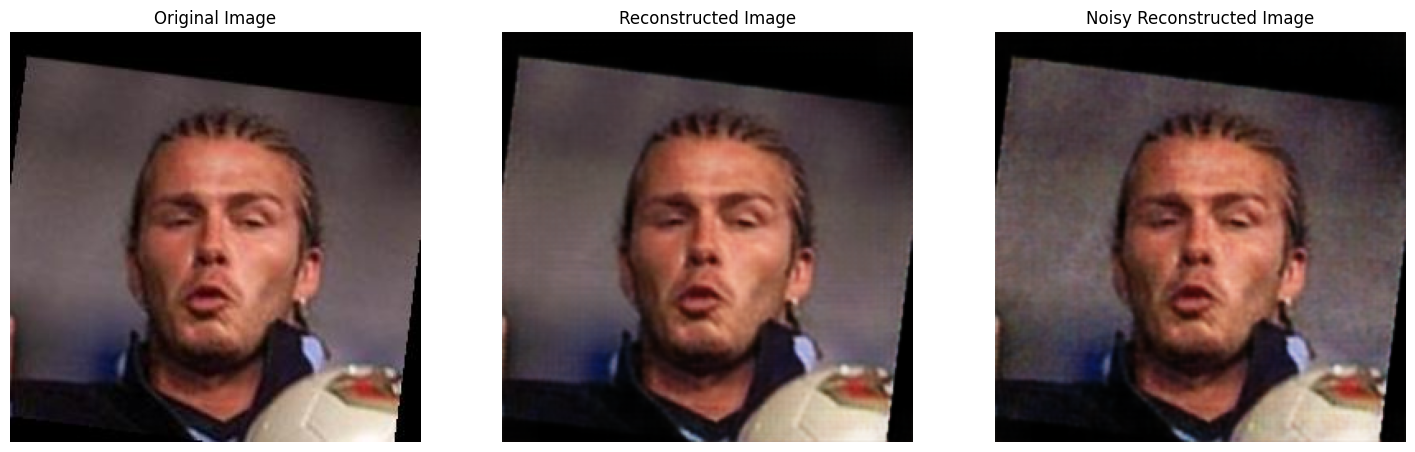

In [ ]:

# Select a random image from the batch
random_index = torch.randint(len(batch_images), size=(1,)).item()
original_image = batch_images[random_index]

# Prepare the selected image for encoding and decoding
model.eval()  # Set the model to evaluation mode
if torch.cuda.is_available():
    model.cuda()  # Move the model to GPU if available
    original_image = original_image.unsqueeze(0).cuda()
else:
    original_image = original_image.unsqueeze(0)

# Encode the original image and introduce noise to the latent representation
with torch.no_grad():
    encoded_image = model.encoder(original_image)
    noise = torch.randn(encoded_image.shape) * 0.5  # Introduce Gaussian noise to the encoded representation (adjust noise level here)
    if torch.cuda.is_available():
        noise = noise.cuda()
    noisy_encoded = encoded_image + noise

    # Decode both the original and noisy latent representations
    reconstructed_image = model.decoder(encoded_image)
    noisy_reconstructed_image = model.decoder(noisy_encoded)

# Function to convert the image tensor for plotting
def to_plot(img):
    img = img.squeeze().detach().cpu().numpy()  # Remove batch dimension and detach from computation graph
    img = np.transpose(img, (1, 2, 0))  # Transpose from (C, H, W) to (H, W, C)
    return img

# Plotting the original image, reconstructed image, and noisy reconstructed image
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(to_plot(original_image))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Reconstructed Image")
plt.imshow(to_plot(reconstructed_image))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Noisy Reconstructed Image")
plt.imshow(to_plot(noisy_reconstructed_image))
plt.axis('off')

plt.show()


The code in this snippet extends the previous step (Step 7) by introducing Gaussian noise to the latent (encoded) representation of an image in an autoencoder model. The effect of this noise on the reconstructed image is then visualized.

1. **Fetching a Batch of Images**:
   - The code starts by retrieving a batch of images from the `dataloader`. Only the images are needed, so the labels or other data associated with the batch are ignored.

2. **Selecting a Random Image**:
   - A random image is chosen from the batch for further processing. The random index is generated, and the corresponding image is fetched.

3. **Model Preparation**:
   - `model.eval()`: The model is switched to evaluation mode. This is crucial for inference as it disables layers like dropout and batch normalization that behave differently during training.
   - GPU Check: The model and image are moved to the GPU if available. This is done for faster computation.

4. **Encoding and Noise Addition**:
   - The selected image is passed through the encoder part of the autoencoder to obtain the latent representation.
   - Gaussian noise is generated (`torch.randn(...) * 0.5`) and added to this latent representation. This noise simulates perturbations or variations in the encoded data.

5. **Decoding the Images**:
   - The original latent representation and the noisy latent representation are both passed through the decoder to reconstruct images from them. This results in two outputs: the reconstruction from the clean latent code and the reconstruction from the noisy latent code.

6. **Image Conversion for Plotting**:
   - A function `to_plot` is defined to transform the PyTorch tensors into a format suitable for plotting with matplotlib. This includes removing the batch dimension, detaching the tensor from the computation graph, converting it to a numpy array, and rearranging the channel order.

7. **Plotting**:
   - The code plots three images side by side: the original image, the reconstructed image from the clean latent code, and the reconstructed image from the noisy latent code.
   - The use of `plt.subplot()` arranges these images in a single row for easy comparison.

### Understanding the Effect of Noise

- **Purpose of Adding Noise**: Adding noise to the latent representation is a common technique in variational autoencoders and denoising autoencoders. It tests the robustness of the autoencoder and its ability to recover the original data from a corrupted latent representation.
  
- **Expected Outcome**: The decoded image from the noisy latent representation is expected to show some level of distortion or difference compared to the clean reconstructed image. The extent of this difference depends on the amount and type of noise added, as well as the model's ability to denoise or interpret the noisy signal.